# Model training


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import glob
from monai import data, transforms
from swincell.utils.data_utils import flow_reshaped



/home/xzhang/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configure training parameters

In [2]:
from types import SimpleNamespace
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = SimpleNamespace(
    checkpoint=None,
    amp=False,
    batch_size=1,
    cellpose=True,   #training with image and generated flows
    max_epochs=5,
    optim_lr=1e-5,
    model='swin',
    num_workers=8,
    optimizer='adam',
    resume=None,
    save_temp_img=False,
    seed=0,
    test_mode=False,
    downsample_factor =3, # downsample the input image if it is too large
    # threshold=0.5,
    weight_decay=0.0001,
    # ROI=(64, 64, 32), 
    ROI=(128, 128, 32), 
    workers=8
)



In [3]:
# data folder
data_dir = '/data/download_data/colon_dataset/colon_30/'
img_full_paths = sorted(glob.glob(os.path.join(data_dir,'images/*')))
label_full_paths = sorted(glob.glob(os.path.join(data_dir,'masks_with_flows/*.tiff')))

N = len(os.listdir(os.path.join(data_dir,'images')))
print('number of images:',N)




number of images: 30


In [4]:
# data split

if len(img_full_paths)<5:
    img_full_paths = img_full_paths * 10
    label_full_paths = label_full_paths * 10
valid_img_full_paths = img_full_paths[::5]
valid_label_full_paths = label_full_paths[::5]

train_img_full_paths = [f for i,f in enumerate(img_full_paths) if i%5 != 0]
train_label_full_paths = [f for i,f in enumerate(label_full_paths) if i%5 != 0]

train_datalist = [{'image':image,'label':label} for image,label in zip(train_img_full_paths,train_label_full_paths)]    
val_datalist = [{'image':image,'label':label} for image,label in zip(valid_img_full_paths,valid_label_full_paths)]  


print(len(train_datalist),len(val_datalist))
# img_shape = (129, 1030, 1300)
# img_shape = (512, 512,96)# nanolive XYZ
img_shape = (1300, 1030, 129) # colon 
img_reshape = (img_shape[0]//args.downsample_factor,img_shape[1]//args.downsample_factor,img_shape[2]//args.downsample_factor)
img_reshape = tuple(int(e) for e in img_reshape)
train_transform = transforms.Compose(
    [

        transforms.LoadImaged(keys=["image", "label"],ensure_channel_first=True),
        flow_reshaped(keys=["label"]),
        transforms.Resized(keys=["image", "label"],spatial_size=img_reshape),

        # transforms.ScaleIntensityRanged(
        #     keys=["image"], a_min=19000, a_max=31000, b_min=0, b_max=1, clip=True
        # ),
        transforms.RandSpatialCropSamplesd(
            keys=["image","label"],
            roi_size=[args.ROI[0],args.ROI[1],args.ROI[2]],

            num_samples=1,
            random_center=True,
            random_size=False,
        ),

        transforms.ToTensord(keys=["image", "label"]),
    ]
)
valid_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.Resized(keys=["image", "label"],spatial_size=(512,512,96)),
        transforms.ScaleIntensityRanged(
            keys=["image"], a_min=21000, a_max=31000, b_min=0, b_max=1, clip=True
            # keys=["image"], a_min=300, a_max=400, b_min=0, b_max=1, clip=True
        ),
        transforms.ToTensord(keys=["image", "label"]),
    ]
)

train_ds = data.Dataset(data=train_datalist, transform=train_transform)
train_loader = data.DataLoader(
        train_ds, batch_size=1, num_workers=8, sampler=None, drop_last=True
    )
valid_ds = data.Dataset(data=val_datalist, transform=valid_transform)
valid_loader = data.DataLoader(
        valid_ds, batch_size=1, num_workers=8, sampler=None, drop_last=True
    )



24 6


torch.Size([1, 1, 64, 64, 32]) torch.Size([1, 4, 64, 64, 32])
metatensor(1.) metatensor(0.)
mask2 metatensor(0.9989) metatensor(-0.9949)
torch.Size([1, 1, 64, 64, 32]) torch.Size([1, 4, 64, 64, 32])
metatensor(1.) metatensor(0.)
mask2 metatensor(0.9252) metatensor(-0.9970)


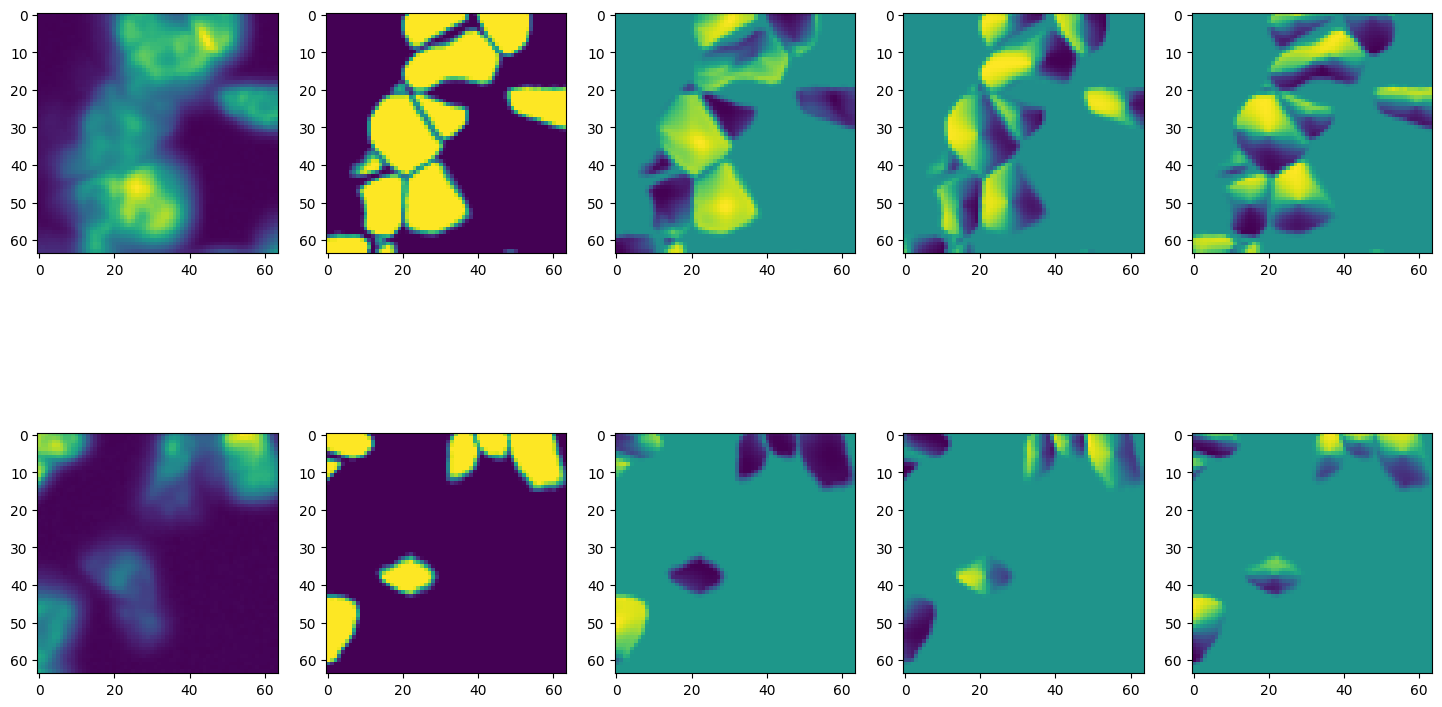

In [12]:
n_row = 2
fig, axes = plt.subplots(n_row, 5,sharex=False, sharey=False, figsize=(18,10))

slice2view = args.ROI[-1]//2
for i in range(n_row):
    datai = next(iter(train_loader))
    img2plot=datai['image']
    label2plot=datai['label']
    print(img2plot.shape, label2plot.shape)

    top= torch.max(img2plot[0,0,:,:,:],dim=-1)[0].detach().cpu()



    mask0= label2plot[0,0,:,:,slice2view].detach().cpu()
    mask1= label2plot[0,1,:,:,slice2view].detach().cpu()
    mask2= label2plot[0,2,:,:,slice2view].detach().cpu()
    mask3= label2plot[0,3,:,:,slice2view].detach().cpu()

    print(mask0.max(),mask0.min())
    print('mask2',mask2.max(),mask2.min())
    axes[i,0].imshow(img2plot[0,0,:,:,slice2view])

    
    axes[i,1].imshow(mask0)
    axes[i,2].imshow(mask1)
    axes[i,3].imshow(mask2)
    axes[i,4].imshow(mask3)



In [5]:
from monai.networks.nets import SwinUNETR
from swincell.utils.utils import AverageMeter
model = SwinUNETR(
            img_size=args.ROI,
            in_channels=1,
            out_channels=4,
            # feature_size=args.feature_size,
            feature_size=48,
            use_checkpoint=None,
        ).to(device)

from torch.nn import MSELoss,BCEWithLogitsLoss
from monai.losses import DiceLoss
loss1 = MSELoss(reduction='mean')
loss2 = DiceLoss(to_onehot_y=False, sigmoid=True)
# dice_loss2 = BCEWithLogitsLoss(reduction='mean')
losses = [loss1,loss2]

optimizer = torch.optim.Adam(model.parameters(), lr=args.optim_lr, weight_decay=1e-1)
loss_per_epoch =[]
# for epoch in range(args.max_epochs):
# # for epoch in range(10):
#     model.train()
#     run_loss = AverageMeter()
#     for i, data in enumerate(train_loader):
#         loss_func1 = losses[0]
#         loss_func2 = losses[1]
#         data, target = data['image'].to(device), data['label'].to(device)
#         logits = model(data)
#         # print(logits.shape,target.shape)
#         #  weight_factor*flow loss     +      cell probability loss
#         # a = loss_func1(logits[:,1:], target[:,1:])
#         # b= loss_func2(logits[:,0], target[:,0])
#         # print(a.item(),b.item())
#         loss = 5*loss_func1(logits[:,1:], target[:,1:]) + loss_func2(logits[:,0], target[:,0])
#         loss.backward()
#         optimizer.step()
#         run_loss.update(loss.item())

#         # run_loss.update(loss.item(), n=args.batch_size)
#         # print(loss_func1.item(),loss_func2.item())
#         loss_per_epoch.append(loss.item())
#         print('Epoch {}/{} {}/{}'.format(epoch, args.max_epochs, i, len(train_loader)), "loss: {:.4f}".format(run_loss.avg))

In [26]:
from swincell.trainer import train_epoch, run_training
# train_epoch(model, train_loader, optimizer, epoch, losses, args)
run_training(model, train_loader, valid_loader, optimizer, losses, args)

TypeError: train_epoch() missing 1 required positional argument: 'args'

Text(0, 0.5, 'loss')

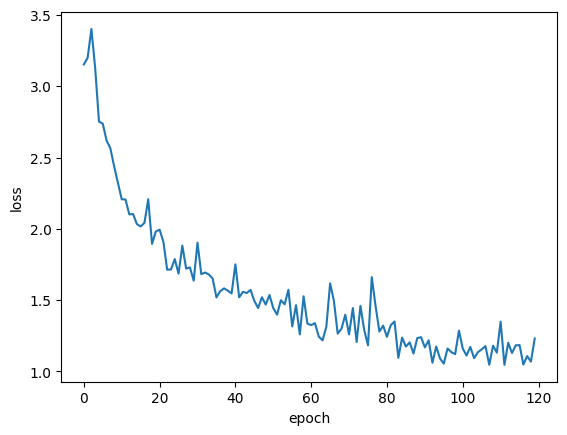

In [22]:
#plot loss
plt.plot(loss_per_epoch)
plt.xlabel('epoch')
plt.ylabel('loss')


In [24]:
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR
from functools import partial
from monai.transforms import Activations, AsDiscrete, Compose,FillHoles

model_path = 'model_final.pt'   #define model path
model = SwinUNETR(
    img_size=args.ROI,
    in_channels=1,
    out_channels=1,
    feature_size=48,
    use_checkpoint=False,
).cuda(0)
model_dict = torch.load(model_path)["state_dict"]
model.load_state_dict(model_dict)


model_inferer = partial(
    sliding_window_inference,
    roi_size=(96,96,96),
    # roi_size=(128,128,96),

    sw_batch_size=2,
    predictor=model,
    overlap=0.5,
)
post_sigmoid = Activations(sigmoid=True)
# post_pred = AsDiscrete(argmax=False, logit_thresh=1.01)
post_pred = AsDiscrete(argmax=False, threshold=0.6)



# print(val_output_convert.shape)


FileNotFoundError: [Errno 2] No such file or directory: 'model_final.pt'

# test inference

In [ ]:
post_trans = Compose([
    Activations(sigmoid=True),
    AsDiscrete(argmax=False, threshold=0.5),
    # RemoveSmallObjects(min_size = 100),
    FillHoles(applied_labels=None, connectivity=2)

])

with torch.no_grad():
        for idx, batch_data in enumerate(valid_loader):
            data_raw, target = batch_data["image"], batch_data["label"]
            data_raw, target = data_raw.cuda(0), target.cuda(0)
            # with autocast(enabled=True):
            logits = model_inferer(data_raw)
            # val_labels_list = decollate_batch(target)
            # val_outputs_list = decollate_batch(logits)
            print(logits.max(),logits.min())
            val_labels_list = target
            val_outputs_list = logits
            # val_output_convert = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list]
            a = post_sigmoid(val_outputs_list)
            print('after sigmoid',a.max(),a.min(),a.median())
            val_output_convert1 = post_pred(post_sigmoid(val_outputs_list))
            val_output_convert2 = post_trans(logits)
            print(val_output_convert1.max(),val_output_convert1.min(),val_output_convert1.median())

In [86]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()